# Installing/importing packages

In [ ]:
# Install required packages
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install transformers[sentencepiece]
!pip install accelerate -U

In [ ]:
# Import required packages
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

# Data processing - Nieuw

In [ ]:
from datasets import load_dataset

# Loading data from HF
yelp_reviews_dataset = load_dataset('yelp_review_full')
app_reviews_dataset = load_dataset('app_reviews')
product_reviews_dataset = load_dataset('generated_reviews_enth')

In [ ]:
app_reviews_dataset

In [ ]:
product_reviews_dataset

In [ ]:
from datasets import concatenate_datasets

# Combine train, val, test data if needed
yelp_reviews = concatenate_datasets([yelp_reviews_dataset["train"], yelp_reviews_dataset["test"]])
app_reviews = app_reviews_dataset['train']
product_reviews = concatenate_datasets([product_reviews_dataset["train"], product_reviews_dataset["validation"], product_reviews_dataset["test"]])

In [ ]:
# Inspect data
print(product_reviews['translation'][0])

In [ ]:
# Rename columns
app_reviews = app_reviews.rename_column("review", "text")
app_reviews = app_reviews.rename_column("star", "label")

product_reviews = product_reviews.rename_column("translation", "text")
product_reviews = product_reviews.rename_column("review_star", "label")

In [ ]:
# Transform 'text' of product reviews to only get english translation
def extract_en(data):
  data['text'] = data['text']['en']
  return data

product_reviews = product_reviews.map(extract_en)

In [ ]:
# Inspect data
product_reviews['text'][0]

## Convert stars to sentiment

In [ ]:
# Unique star labels
print(f"Yelp: {set(yelp_reviews['label'])}")    # 0-4 scale
print(f"App: {set(app_reviews['label'])}")      # 1-5 scale
print(f"Product: {set(app_reviews['label'])}")  # 1-5 scale

In [ ]:
# Function to convert stars to sentiment class 'positive', 'neutral', 'negative'
def transform_labels(data, max_star):
  if data['label'] <= (max_star-3):
      data['label_class'] = 'negative'
      data['label_class_num'] = 0
  elif data['label'] == (max_star-2):
      data['label_class'] = 'neutral'
      data['label_class_num'] = 1
  else:  # data['label'] is 3, 4 or 5 (depending on max stars)
      data['label_class'] = 'positive'
      data['label_class_num'] = 2
  return data

In [ ]:
# Convert labels to labels_new
yelp_reviews = yelp_reviews.map(transform_labels, fn_kwargs={'max_star': 4})
app_reviews = app_reviews.map(transform_labels, fn_kwargs={'max_star': 5})
product_reviews = product_reviews.map(transform_labels, fn_kwargs={'max_star': 5})

In [ ]:
# Inspect data
print(yelp_reviews['label_class'][0], yelp_reviews['text'][0])
print(app_reviews['label_class'][150], app_reviews['text'][150])
print(product_reviews['label_class'][100], product_reviews['text'][100])

## Train-val-test split

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Function to make train, val, test split of df and convert it back HF dataset object
def split_data(data):
  # Data to pandas
  df = data.to_pandas()

  # Split into train and intermediate set
  train_df, intermediate_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label_class'])

  # Split the intermediate set into validation and test sets
  validation_df, test_df = train_test_split(intermediate_df, test_size=0.5, random_state=42, stratify=intermediate_df['label_class'])

  # Convert DataFrames into Hugging Face Datasets
  datasets = {
      'train': Dataset.from_pandas(train_df),
      'validation': Dataset.from_pandas(validation_df),
      'test': Dataset.from_pandas(test_df)
  }

  # Create a single Hugging Face Dataset with splits
  dataset = DatasetDict(datasets).flatten()

  return dataset

In [ ]:
yelp_reviews = split_data(yelp_reviews)
yelp_reviews

In [ ]:
app_reviews = split_data(app_reviews)
app_reviews

In [ ]:
product_reviews = split_data(product_reviews)
product_reviews

## Force class balance train sets

### Yelp reviews

In [ ]:
df_yelp_train = yelp_reviews['train'].to_pandas()
df_yelp_train['label_class'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes (Yelp Reviews)')
plt.show()

counts = df_yelp_train['label_class'].value_counts(ascending=True)
print(counts)

In [ ]:
from sklearn.utils import resample

# Funtion to undersample classes to min observations minority class
def undersample_classes(df):
  # Get the counts for each class
  counts = df['label_class'].value_counts()

  # Find the class with the least samples
  min_class_count = counts.min()

  # Create a list containing dataframes for each class
  dfs = [df[df['label_class'] == label] for label in counts.index]

  # Undersample each dataframe in the list to have min_class_count examples
  dfs_undersampled = [resample(df, replace=False, n_samples=min_class_count, random_state=42) for df in dfs]

  # Combine undersampled dataframes
  df_balanced = pd.concat(dfs_undersampled)

  # Shuffle for good measure
  df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

  return df_balanced

In [ ]:
df_yelp_train_bal = undersample_classes(df_yelp_train)

In [ ]:
counts = df_yelp_train_bal['label_class'].value_counts(ascending=True)
print(counts)

### App reviews

In [ ]:
df_app_train = app_reviews['train'].to_pandas()
df_app_train['label_class'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes (App Reviews)')
plt.show()

counts = df_app_train['label_class'].value_counts(ascending=True)
print(counts)

In [ ]:
df_app_train_bal = undersample_classes(df_app_train)

In [ ]:
counts = df_app_train_bal['label_class'].value_counts(ascending=True)
print(counts)

### Product reviews

In [ ]:
df_product_train = product_reviews['train'].to_pandas()
df_product_train['label_class'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes (Product Reviews)')
plt.show()

counts = df_product_train['label_class'].value_counts(ascending=True)
print(counts)

In [ ]:
df_product_train_bal = undersample_classes(df_product_train)

In [ ]:
counts = df_product_train_bal['label_class'].value_counts(ascending=True)
print(counts)

## Equal training set sizes

In [ ]:
# Function to make sure all training sets have an equal number of observations
def sample_dfs(df1, df2, df3):
  min_rows = ((min(df1.shape[0], df2.shape[0], df3.shape[0])) / 3) -1 # Determine the minimum number of rows / 3 classes (-1 to round down)
  min_rows = int(round(min_rows, 0))

  df1_sampled = df1.groupby('label_class').apply(lambda x: x.sample(n=min_rows, random_state=42))
  df2_sampled = df2.groupby('label_class').apply(lambda x: x.sample(n=min_rows, random_state=42))
  df3_sampled = df3.groupby('label_class').apply(lambda x: x.sample(n=min_rows, random_state=42))

  return df1_sampled, df2_sampled, df3_sampled

In [ ]:
df_yelp_train_bal_sampled, df_app_train_bal_sampled, df_product_train_bal_sampled = sample_dfs(df_yelp_train_bal, df_app_train_bal, df_product_train_bal)

In [ ]:
counts = df_yelp_train_bal_sampled['label_class'].value_counts(ascending=True)
print('Yelp train:')
print(counts)

In [ ]:
counts = df_app_train_bal_sampled['label_class'].value_counts(ascending=True)
print('App train:')
print(counts)

In [ ]:
counts = df_product_train_bal_sampled['label_class'].value_counts(ascending=True)
print('Product train:')
print(counts)

## Replace balanced and sampled training data

In [ ]:
# Replace new training set
def replace_train(dataset, df_train):
  new_train_dataset = Dataset.from_pandas(df_train[['text', 'label', 'label_class', 'label_class_num']])
  dataset['train'] = new_train_dataset
  return dataset

In [ ]:
yelp_reviews_final = replace_train(yelp_reviews, df_yelp_train_bal_sampled)
app_reviews_final = replace_train(app_reviews, df_app_train_bal_sampled)
product_reviews_final = replace_train(product_reviews, df_product_train_bal_sampled)

In [ ]:
# Inspect data to check if text and labels still match
print(yelp_reviews_final['train']['text'][48000])
print(yelp_reviews_final['train']['label'][48000])
print(yelp_reviews_final['train']['label_class'][48000])

In [ ]:
# Inspect data to check if text and labels still match
print(app_reviews_final['train']['text'][21000])
print(app_reviews_final['train']['label'][21000])
print(app_reviews_final['train']['label_class'][21000])

In [ ]:
# Inspect data to check if text and labels still match
print(product_reviews_final['train']['text'][20])
print(product_reviews_final['train']['label'][20])
print(product_reviews_final['train']['label_class'][20])

## Undersample datasets (keep original class balance)

In [ ]:
def undersample_data(dataset, set, samples):
  df = dataset[set].to_pandas()

  # Undersample test_set to n_samples, stratify=True
  df_undersampled = resample(df, replace=False, n_samples=samples, stratify=df, random_state=42)

  # Store new test dataset
  new_dataset = Dataset.from_pandas(df_undersampled[['text', 'label', 'label_class', 'label_class_num']])
  dataset[set] = new_dataset

  return dataset

In [ ]:
# Undersample train
yelp_reviews_final = undersample_data(yelp_reviews_final, 'train', 30000)
app_reviews_final = undersample_data(app_reviews_final, 'train', 30000)
product_reviews_final = undersample_data(product_reviews_final, 'train', 30000)

In [ ]:
# Undersample test
yelp_reviews_final = undersample_data(yelp_reviews_final, 'test', 10000)
app_reviews_final = undersample_data(app_reviews_final, 'test', 10000)
product_reviews_final = undersample_data(product_reviews_final, 'test', 10000)

In [ ]:
# Undersample val
yelp_reviews_final = undersample_data(yelp_reviews_final, 'validation', 10000)
app_reviews_final = undersample_data(app_reviews_final, 'validation', 10000)
product_reviews_final = undersample_data(product_reviews_final, 'validation', 10000)

## Drop and rename needed columns

In [ ]:
# Keep necessary columns
columns_to_keep = ['text', 'label_class', 'label_class_num']

def drop_and_rename_cols(dataset):
  # Drop
  dataset['train']  = dataset['train'].remove_columns([col for col in dataset['train'].column_names if col not in columns_to_keep])
  dataset['validation']  = dataset['validation'].remove_columns([col for col in dataset['validation'].column_names if col not in columns_to_keep])
  dataset['test']  = dataset['test'].remove_columns([col for col in dataset['test'].column_names if col not in columns_to_keep])

  # Rename
  dataset = dataset.rename_column("label_class_num", "label")
  dataset = dataset.rename_column("label_class", "label_text")

  return dataset

In [ ]:
yelp_reviews_final = drop_and_rename_cols(yelp_reviews_final)
app_reviews_final = drop_and_rename_cols(app_reviews_final)
product_reviews_final = drop_and_rename_cols(product_reviews_final)

In [ ]:
# Check final dataset
yelp_reviews_final

In [ ]:
# Check final dataset
app_reviews_final

In [ ]:
# Check final dataset
product_reviews_final

##Wordcloud and exploratory analytics

In [ ]:
# Check average character lengths
yelp_text = yelp_reviews_final['train'].to_pandas()
avg_char_yelp = np.mean(yelp_text['text'].str.len())
avg_char_yelp


In [ ]:
# Check average character lengths
app_text = app_reviews_final['train'].to_pandas()
avg_char_app = np.mean(app_text['text'].str.len())
avg_char_app

In [ ]:
# Check average character lengths
product_text = product_reviews_final['train'].to_pandas()
avg_char_product = np.mean(product_text['text'].str.len())
avg_char_product

In [ ]:
product_text.head()

In [ ]:
# @title label

from matplotlib import pyplot as plt
product_text['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
import contractions
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = nltk.stem.WordNetLemmatizer()

#Define punctiations and numbers
punctuation = ['—', '’', '“', '!','"','#','$','%','&', '\'', ',', '(', ')', '*', '+', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#Expands contractions, e.g. 'I'm' becomes 'I' and 'am'.
def correct_contractions(text: str):
    expanded_words = [contractions.fix(word) for word in text.split()] # Fix all contractions found, using the contractions module
    expanded_text = ' '.join(expanded_words)
    return expanded_text

#Removes list of characters, that are specified, from text.
def remove_specified_characters(text: str, specified_character: list):
    cleaned_text = re.sub('[' + ''.join(specified_character) + ']', '', text)
    return cleaned_text

#Removes stopwords from text.
def remove_stopwords(text: str):
    stop_words = stopwords.words('english')
    stop_words.extend(['n'])
    words = text.split()
    cleaned_text = ' '.join([w for w in words if w not in stop_words])
    return cleaned_text

#Lemmatize the text.
def lemmatize(text: str):
    words = text.split()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized_text

#Main function where a column 'cleaned_tweets' is added that contains the cleand tweets from the column 'text'.
def clean_text(data: pd.DataFrame(), col: str):
    result = data.copy()
    result['cleaned_com'] = result[col].str.lower() # To lower case
    result['cleaned_com'] = result['cleaned_com'].replace(r'http\S+', '', regex = True) # Removes URLs
    result['cleaned_com'] = result['cleaned_com'].apply(correct_contractions) # Corrects contractions
    result['cleaned_com'] = result['cleaned_com'].apply(remove_specified_characters, specified_character = punctuation) # Remove punctuation
    result['cleaned_com'] = result['cleaned_com'].apply(remove_specified_characters, specified_character = numbers) # Remove numbers
    result['cleaned_com'] = result['cleaned_com'].apply(remove_stopwords) # Remove stopwords
    result['cleaned_com'] = result['cleaned_com'].apply(lemmatize) # Lemmatize
    return result

#clean data
clean_data_yelp = clean_text(yelp_text, 'text')
clean_data_app = clean_text(app_text, 'text')
clean_data_product = clean_text(product_text, 'text')


In [ ]:
def get_top_10_words(col):
    all_words = ' '.join(col)  # Combine all text into one string
    words = re.findall(r'\b\w+\b', all_words.lower())
    word_counts = Counter(words)

    top_10_words = word_counts.most_common(11)

    for word, count in top_10_words:
        print(word, ':', count)

get_top_10_words(clean_data_yelp['cleaned_com'])

In [ ]:
get_top_10_words(clean_data_app['cleaned_com'])

In [ ]:
get_top_10_words(clean_data_product['cleaned_com'])

# Zero-Shot

## Yelp reviews prediction

In [ ]:
# Test inputs
test_set = yelp_reviews_final['test']['text'][50:53]
print(test_set)

['I\'ve only been here once, but thought I\'d share after reading some other reviews. \\n\\nFirst off, this is NOT TexMex. I\'m not sure what I would classify it as, maybe AmeriMex, but definitely NOT TexMex. \\n\\nNow that I have that out of the way, I\'ll say that I like El Cancun. \\n\\nI do not like this El Cancun. \\n\\nWhile it looks decent on the outside and the inside, the food and service were simply terrible. Chicken was very watered down, the salsa was flavorless, and the service make a fast food chain look really good. Just a poor, poor experience at this location overall. If this was the only El Cancun in Charlotte, I would feel the same way many posters do and just never come back. \\n\\nLuckily for me, I live in Rock Hill. There\'s an El Cancun here. And it\'s pretty awesome. I won\'t give it a full on review because this isn\'t really the place for it, but suffice it to say that if you\'re in RH and you see the El Cancun and you go \\"ugh, no way that place is terrible\

In [ ]:
test_set_answ = yelp_reviews_final['test']['label_text'][50:53]
print(test_set_answ)

['negative', 'positive', 'neutral']


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"  # Use GPU if available

# Load the zero-shot classifier
model_name = "cross-encoder/nli-deberta-v3-xsmall"
#model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
#model_name = "typeform/distilbert-base-uncased-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# Define classifier
classifier = pipeline("zero-shot-classification",
                      model = model,
                      tokenizer = tokenizer,
                      device = device)

# Define candidate labels
candidate_labels = ['negative', 'neutral', 'positive']

tokenizer_config.json:   0%|          | 0.00/419 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/283M [00:00<?, ?B/s]

In [ ]:
# Yelp predictions using zero-shot classifier
predictions = classifier(yelp_reviews_final['test']['text'], candidate_labels)

yelp_pred_label_text = []
yelp_pred_label = []

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Retrieve highest scoring label/class
for prediction in predictions:
  predicted_label_text = prediction['labels'][0]   # Prediction output auto sorts highest to largest scores, so 0 index is highest scoring label
  predicted_label = label_mapping[predicted_label_text]

  # Append labels to lists
  yelp_pred_label_text.append(predicted_label_text)
  yelp_pred_label.append(predicted_label)

In [ ]:
import csv
from google.colab import drive

# Save predictions to Google Drive
drive.mount('/content/drive')

# Save predictions to the CSV file
with open('/content/drive/My Drive/DEBERTA_yelp_zero_shot_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Header row
    writer.writerow(['Review Text', 'Predicted Label Text', 'Predicted Label'])

    # Data rows
    for i in tqdm(range(len(yelp_reviews_final['test']['text']))):
        writer.writerow([yelp_reviews_final['test']['text'][i],
                         yelp_pred_label_text[i],
                         yelp_pred_label[i]])

Mounted at /content/drive


In [ ]:
# Score zero-shot
from sklearn.metrics import classification_report

y_true = yelp_reviews_final['test']['label']

df_pred = pd.read_csv('/content/drive/My Drive/DEBERTA_yelp_zero_shot_predictions.csv')  # Retrieve predictions from csv
y_pred = df_pred['Predicted Label']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      4083
           1       0.51      0.07      0.12      1989
           2       0.72      0.90      0.80      3928

    accuracy                           0.73     10000
   macro avg       0.66      0.62      0.58     10000
weighted avg       0.69      0.73      0.67     10000



## App reviews prediction

In [ ]:
# App predictions using zero-shot classifier
predictions = classifier(app_reviews_final['test']['text'], candidate_labels)

app_pred_label_text = []
app_pred_label = []

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Retrieve highest scoring label/class
for prediction in predictions:
    predicted_label_text = prediction['labels'][0]   # Prediction output auto sorts highest to largest scores, so 0 index is highest scoring label
    predicted_label = label_mapping[predicted_label_text]

    # Append labels to lists
    app_pred_label_text.append(predicted_label_text)
    app_pred_label.append(predicted_label)


In [ ]:
import csv
from google.colab import drive

# Save predictions to Google Drive
drive.mount('/content/drive')

# Save predictions to the CSV file
with open('/content/drive/My Drive/DEBERTA_app_zero_shot_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Header row
    writer.writerow(['Review Text', 'Predicted Label Text', 'Predicted Label'])

    # Data rows
    for i in tqdm(range(len(app_reviews_final['test']['text']))):
        writer.writerow([app_reviews_final['test']['text'][i],
                         app_pred_label_text[i],
                         app_pred_label[i]])


Mounted at /content/drive


In [ ]:
# Score zero-shot
from sklearn.metrics import classification_report

y_true = app_reviews_final['test']['label']

df_pred = pd.read_csv('/content/drive/My Drive/DEBERTA_app_zero_shot_predictions.csv')  # Retrieve predictions from csv
y_pred = df_pred['Predicted Label']

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.51      0.80      0.62      1817
           1       0.17      0.07      0.10       759
           2       0.90      0.83      0.86      7424

    accuracy                           0.77     10000
   macro avg       0.53      0.57      0.53     10000
weighted avg       0.77      0.77      0.76     10000



## Product reviews prediction

In [ ]:
# Product predictions using zero-shot classifier
predictions = classifier(product_reviews_final['test']['text'], candidate_labels)

product_pred_label_text = []
product_pred_label = []

label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Retrieve highest scoring label/class
for prediction in predictions:
    predicted_label_text = prediction['labels'][0]   # Prediction output auto sorts highest to largest scores, so 0 index is highest scoring label
    predicted_label = label_mapping[predicted_label_text]

    # Append labels to lists
    product_pred_label_text.append(predicted_label_text)
    product_pred_label.append(predicted_label)


In [ ]:
import csv
from google.colab import drive

# Save predictions to Google Drive
drive.mount('/content/drive')

# Save predictions to the CSV file
with open('/content/drive/My Drive/DEBERTA_product_zero_shot_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Header row
    writer.writerow(['Review Text', 'Predicted Label Text', 'Predicted Label'])

    # Data rows
    for i in tqdm(range(len(product_reviews_final['test']['text']))):
        writer.writerow([product_reviews_final['test']['text'][i],
                         product_pred_label_text[i],
                         product_pred_label[i]])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 10000/10000 [02:27<00:00, 67.93it/s]


In [ ]:
# Score zero-shot
from sklearn.metrics import classification_report

y_true = product_reviews_final['test']['label']

df_pred = pd.read_csv('/content/drive/My Drive/DEBERTA_product_zero_shot_predictions.csv')  # Retrieve predictions from csv
y_pred = df_pred['Predicted Label']

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.79      0.81      5221
           1       0.30      0.08      0.12      1590
           2       0.63      0.90      0.74      3189

    accuracy                           0.71     10000
   macro avg       0.59      0.59      0.56     10000
weighted avg       0.68      0.71      0.68     10000



# Fine-tuned Yelp reviews (training)

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Loading model
model_name = "cross-encoder/nli-deberta-v3-xsmall"
#model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
#model_name = "typeform/distilbert-base-uncased-mnli"
num_labels = 3
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=3)
         .to(device))
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
import torch.nn as nn

# Adapt model for three labels
model.classifier = nn.Linear(model.config.hidden_size, 3)

In [ ]:
def tokenize_function(batch):
  text = batch["text"]
  return tokenizer(text, padding='max_length', truncation=True, max_length=256)

In [ ]:
yelp_reviews_final_encoded = yelp_reviews_final.map(tokenize_function, batched=True, batch_size=64)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
yelp_reviews_final_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


In [ ]:
from transformers import TrainingArguments, Trainer

# Defining training args
batch_size = 32
logging_steps = len(yelp_reviews_final_encoded['train']) // batch_size
model_name_arg = f"{model_name}-finetuned-yelp"
training_args = TrainingArguments(output_dir=model_name_arg,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  metric_for_best_model="eval_loss",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
trainer_yelp = Trainer(
    model=model,
    args=training_args,
    train_dataset=yelp_reviews_final_encoded['train'],
    eval_dataset=yelp_reviews_final_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer_yelp.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.622700,0.458456,0.808900,0.813255,0.820039,0.808900


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.622700,0.458456,0.808900,0.813255,0.820039,0.808900
2,0.489300,0.467052,0.808600,0.818277,0.837871,0.808600
3,0.438700,0.467258,0.811900,0.820481,0.837007,0.811900


TrainOutput(global_step=2814, training_loss=0.5168022962860291, metrics={'train_runtime': 2127.5594, 'train_samples_per_second': 42.302, 'train_steps_per_second': 1.323, 'total_flos': 2964432245760000.0, 'train_loss': 0.5168022962860291, 'epoch': 3.0})

TrainOutput(global_step=2814, training_loss=0.5168022962860291, metrics={'train_runtime': 2127.5594, 'train_samples_per_second': 42.302, 'train_steps_per_second': 1.323, 'total_flos': 2964432245760000.0, 'train_loss': 0.5168022962860291, 'epoch': 3.0})

#Fine-tuned App reviews (training)

In [ ]:
# Tokenize data
app_reviews_final_encoded = app_reviews_final.map(tokenize_function, batched=True, batch_size=64)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
app_reviews_final_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})

In [ ]:
from transformers import TrainingArguments, Trainer

# Defining training args
batch_size = 32
logging_steps = len(app_reviews_final_encoded['train']) // batch_size
model_name_arg = f"{model_name}-finetuned-app"
training_args = TrainingArguments(output_dir=model_name_arg,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  metric_for_best_model="eval_loss",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
trainer_app = Trainer(
    model=model,
    args=training_args,
    train_dataset=app_reviews_final_encoded['train'],
    eval_dataset=app_reviews_final_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [ ]:
trainer_app.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.813400,0.646284,0.781500,0.802562,0.833187,0.781500
2,0.728300,0.625819,0.773500,0.797985,0.834525,0.773500
3,0.694900,0.653919,0.762200,0.788884,0.829115,0.762200


TrainOutput(global_step=2814, training_loss=0.7453940692486793, metrics={'train_runtime': 2084.8451, 'train_samples_per_second': 43.169, 'train_steps_per_second': 1.35, 'total_flos': 2964432245760000.0, 'train_loss': 0.7453940692486793, 'epoch': 3.0})

In [ ]:
trainer_app.evaluate()

{'eval_loss': 0.6258194446563721,
 'eval_accuracy': 0.7735,
 'eval_f1': 0.7979847018626915,
 'eval_precision': 0.8345245410956937,
 'eval_recall': 0.7735,
 'eval_runtime': 80.0016,
 'eval_samples_per_second': 124.998,
 'eval_steps_per_second': 3.912,
 'epoch': 3.0}

#Fine-tuned Product reviews (training)

In [ ]:
product_reviews_final_encoded = product_reviews_final.map(tokenize_function, batched=True, batch_size=64)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

# Defining training args
batch_size = 32
logging_steps = len(product_reviews_final_encoded['train']) // batch_size
model_name_arg = f"{model_name}-finetuned-product"
training_args = TrainingArguments(output_dir=model_name_arg,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  metric_for_best_model="eval_loss",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [ ]:
trainer_product = Trainer(
    model=model,
    args=training_args,
    train_dataset=product_reviews_final_encoded['train'],
    eval_dataset=product_reviews_final_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


In [ ]:
trainer_product.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.676700,0.542805,0.755800,0.775529,0.822297,0.755800


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.676700,0.542805,0.755800,0.775529,0.822297,0.755800
2,0.530600,0.565726,0.754600,0.777374,0.836022,0.754600
3,0.481100,0.544369,0.768000,0.787040,0.834152,0.768000


TrainOutput(global_step=2814, training_loss=0.5626957613098427, metrics={'train_runtime': 2078.5084, 'train_samples_per_second': 43.3, 'train_steps_per_second': 1.354, 'total_flos': 2964432245760000.0, 'train_loss': 0.5626957613098427, 'epoch': 3.0})

In [ ]:
trainer_product.evaluate()

{'eval_loss': 0.5428051948547363,
 'eval_accuracy': 0.7558,
 'eval_f1': 0.7755286945814401,
 'eval_precision': 0.8222973039296803,
 'eval_recall': 0.7558,
 'eval_runtime': 83.4847,
 'eval_samples_per_second': 119.782,
 'eval_steps_per_second': 3.749,
 'epoch': 3.0}

# Performance fine-tuned models on test sets

## Fine-tuned Yelp

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred['label_ids']
    # If your predictions are logits (raw outputs from model), you'll need to apply argmax.
    # If they are already class indices, you can skip the argmax step.
    preds = pred['predictions'].argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted", zero_division=0)
    recall = recall_score(labels, preds, average="weighted", zero_division=0)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


**Yelp on Yelp**

In [ ]:
# Tuned yelp on yelp set
preds_tuned_yelp_on_yelp_test = trainer_yelp.predict(yelp_reviews_final_encoded['test'])
preds_tuned_yelp_on_yelp_test.metrics

NameError: name 'trainer_yelp' is not defined

**Yelp on App**

In [ ]:
# Tuned yelp on app set
preds_tuned_yelp_on_app_test = trainer_yelp.predict(app_reviews_final_encoded['test'])
preds_tuned_yelp_on_app_test.metrics

{'test_loss': 0.7656723260879517,
 'test_accuracy': 0.7119,
 'test_f1': 0.7428485385468317,
 'test_precision': 0.7967778360041605,
 'test_recall': 0.7119,
 'test_runtime': 73.4907,
 'test_samples_per_second': 136.072,
 'test_steps_per_second': 4.259}

**Yelp on Product**

In [ ]:
# Tuned yelp on product set
preds_tuned_yelp_on_product_test = trainer_yelp.predict(product_reviews_final_encoded['test'])
preds_tuned_yelp_on_product_test.metrics

{'test_loss': 0.6477729678153992,
 'test_accuracy': 0.7342,
 'test_f1': 0.7550312175034268,
 'test_precision': 0.7945025023234096,
 'test_recall': 0.7342,
 'test_runtime': 74.5762,
 'test_samples_per_second': 134.091,
 'test_steps_per_second': 4.197}

## Fine-tuned App

**App on App**

In [ ]:
# Predictions on the app reviews test set
preds_tuned_app_on_app_test = trainer_app.predict(app_reviews_final_encoded['test'])
preds_tuned_app_on_app_test.metrics

{'test_loss': 0.6329537034034729,
 'test_accuracy': 0.7712,
 'test_f1': 0.7982398079226123,
 'test_precision': 0.8383733007357741,
 'test_recall': 0.7712,
 'test_runtime': 74.0224,
 'test_samples_per_second': 135.094,
 'test_steps_per_second': 4.228}

**App on Yelp**

In [ ]:
# Tuned app on yelp set
preds_tuned_app_on_yelp_test = trainer_app.predict(yelp_reviews_final_encoded['test'])
preds_tuned_app_on_app_test.metrics

{'test_loss': 0.6329537034034729,
 'test_accuracy': 0.7712,
 'test_f1': 0.7982398079226123,
 'test_precision': 0.8383733007357741,
 'test_recall': 0.7712,
 'test_runtime': 74.0224,
 'test_samples_per_second': 135.094,
 'test_steps_per_second': 4.228}

**App on Product**

In [ ]:
# Tuned app on product set
preds_tuned_app_on_product_test = trainer_app.predict(product_reviews_final_encoded['test'])
preds_tuned_app_on_product_test.metrics

{'test_loss': 0.8510289788246155,
 'test_accuracy': 0.6444,
 'test_f1': 0.6732494088449558,
 'test_precision': 0.7919947013429002,
 'test_recall': 0.6444,
 'test_runtime': 74.6355,
 'test_samples_per_second': 133.984,
 'test_steps_per_second': 4.194}

## Fine-tuned Product

**Product on Product**

In [ ]:
# Predictions on the product reviews test set
preds_tuned_product_on_product_test = trainer_product.predict(product_reviews_final_encoded['test'])
preds_tuned_product_on_product_test.metrics


{'test_loss': 0.5422113537788391,
 'test_accuracy': 0.76,
 'test_f1': 0.7787232531913209,
 'test_precision': 0.8217663173306391,
 'test_recall': 0.76,
 'test_runtime': 79.4172,
 'test_samples_per_second': 125.917,
 'test_steps_per_second': 3.941}

**Product on Yelp**

In [ ]:
# Tuned product on yelp set
preds_tuned_product_on_yelp_test = trainer_product.predict(yelp_reviews_final_encoded['test'])
preds_tuned_product_on_yelp_test.metrics

{'test_loss': 0.5345503091812134,
 'test_accuracy': 0.7719,
 'test_f1': 0.7785623511622347,
 'test_precision': 0.7889249572820719,
 'test_recall': 0.7719,
 'test_runtime': 75.6274,
 'test_samples_per_second': 132.227,
 'test_steps_per_second': 4.139}

**Product on App**

In [ ]:
# Tuned product on app set
preds_tuned_product_on_app_test = trainer_product.predict(app_reviews_final_encoded['test'])
preds_tuned_product_on_app_test.metrics

{'test_loss': 0.7539466023445129,
 'test_accuracy': 0.6901,
 'test_f1': 0.7200464245788616,
 'test_precision': 0.7883558460422916,
 'test_recall': 0.6901,
 'test_runtime': 73.6855,
 'test_samples_per_second': 135.712,
 'test_steps_per_second': 4.248}

# Plot

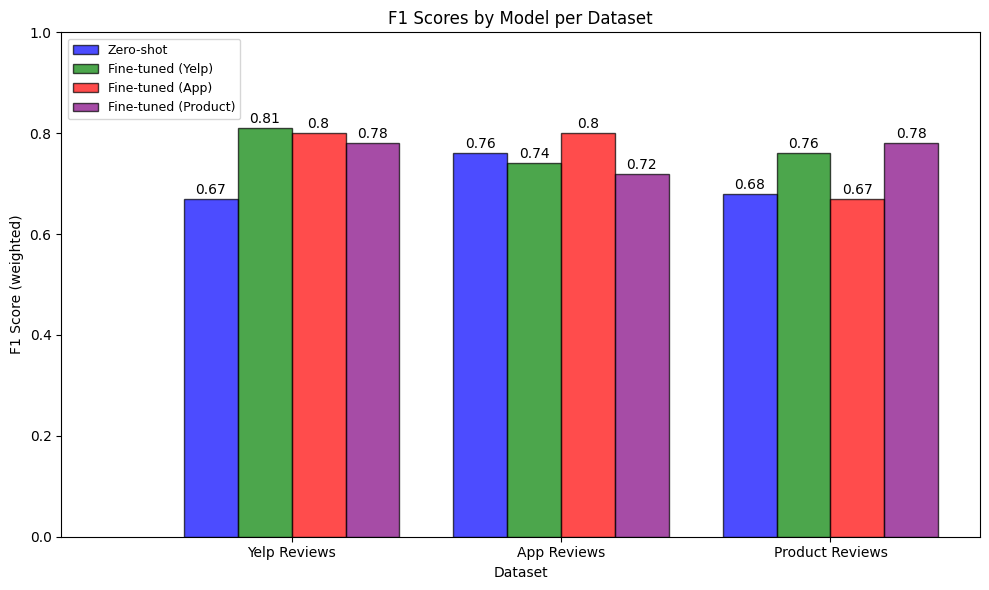

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# F1 scores for each model across three datasets
f1_scores = {
    'Zero-shot': [0.67, 0.76, 0.68],
    'Fine-tuned (Yelp)': [0.81, 0.74, 0.76],
    'Fine-tuned (App)': [0.80, 0.80, 0.67],
    'Fine-tuned (Product)': [0.78, 0.72, 0.78]
}

# Datasets
datasets = ['Yelp Reviews', 'App Reviews', 'Product Reviews']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))


# Set width of bars
bar_width = 0.2

# Set up positions for the bars
index = np.arange(len(datasets))

# Define colors for the bars
colors = ['blue', 'green', 'red', 'purple']

models = list(f1_scores.keys())
handles = []  # to store custom legend handles
for i, model in enumerate(models):
    bar = plt.bar(index + i * bar_width, f1_scores[model], bar_width, label=model, color=colors[i], alpha=0.7, edgecolor='black')
    handles.append(bar[0])  # append the bar as a custom legend handle
    for j, score in enumerate(f1_scores[model]):
        plt.text(index[j] + i * bar_width, score + 0.01, str(score), ha='center')

# Plot an invisible bar to use as a custom legend handle
invisible_bar = plt.bar(0, 0, color='white', hatch='', alpha=0)
handles.append(invisible_bar[0])

# Create legend with custom handles
plt.legend(handles, models + [''], loc='upper right')



# Labeling
ax.set_xlabel('Dataset')
ax.set_ylabel('F1 Score (weighted)')
ax.set_title('F1 Scores by Model per Dataset')
ax.set_xticks(index + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1)  # Set y-axis limit to 1
ax.legend(loc='upper left', prop={'size': 9})  # Adjust legend size

plt.tight_layout()

plt.show()
